# 第6章 算法链与管道
对于许多机器学习算法，你提供的特定数据表示非常重要，我们首先对数据进行缩放，然后手动合并特征，再利用无监督机器学习来学习特征。因此，大多数机器学习应用不仅需要应用单个算法，而且还需要将许多不同的处理步骤和机器学习模型链接在一起。

本章将介绍如何使用`Pipeline`类来简化构建变换和模型链的过程。我们将重点介绍如何将`Pipeline`和`GridSearchCV`结合起来，从而同时搜索所有处理步骤中的参数。

举一个例子来说明模型链的重要性。我们通过使用`MinMaxScaler`进行预处理来大大提高核`SVM`在`cancer数据集`上的性能。下面这些代码实现了划分数据、计算最小值和最大值、缩放数据与训练`SVM`：

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mglearn

from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 加载并划分数据
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

# 计算训练数据的最小值和最大值
scaler = MinMaxScaler().fit(X_train)

# 对训练数据进行缩放
X_train_scaled = scaler.transform(X_train)
svm = SVC()

# 在缩放后的训练数据上学习SVM
svm.fit(X_train_scaled, y_train)

# 对测试数据进行缩放，并计算缩放后的数据的分数
X_test_scaled = scaler.transform(X_test)
svm.score(X_test_scaled, y_test)

0.95104895104895104

## 6.1 用预处理进行参数选择
现在我们希望利用`GridSearchCV`找到更好的`SVC`参数，一种简单的方法如下所示：

In [2]:
from sklearn.model_selection import GridSearchCV

# 只是为了便于说明，不要在实践中使用这些代码！
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best set score: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("Best parameters: ", grid.best_params_)

Best cross-validation accuracy: 0.98
Best set score: 0.97
Best parameters:  {'gamma': 1, 'C': 1}


上面的代码中有一个不易察觉的陷阱。在缩放数据时，我们使用了训练集中的所有数据来找到训练的方法。然后，我们使用缩放后的训练数据来运行带交叉验证的网格搜索。对于交叉验证中的每次划分，原始训练集的一部分被划分为训练部分，另一部分被划分为测试部分。测试部分用于度量在训练部分上所训练的模型在新数据上的表现。但是，我们在缩放数据时已经使用过测试部分中所包含的信息。*请记住，交叉验证每次划分的测试部分都是训练集的一部分，我们使用整个训练集的信息来找到数据的正确缩放。*

对于模型来说，这些数据与新数据看起来截然不同。如果我们观察新数据(比如测试集中的数据)，那么这些数据并没有用于对训练数据进行缩放，其最大值和最小值也可能与训练数据不同。下面这个例子(`图6-1`)显示了交叉验证与最终评估这两个过程中数据处理的不同之处：
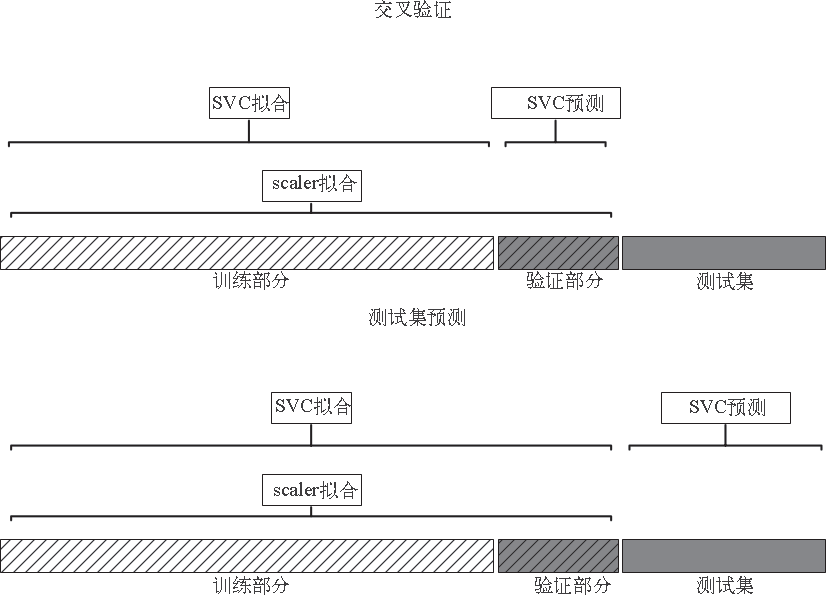

因此，对于建模过程，交叉验证中的划分无法正确地反映新数据的特征。我们已经将这部分数据的信息泄露给建模过程。这将导致在交叉验证过程中得到过于乐观的结果，并可能会导致选择次优的参数。

为了解决这个问题，在交叉验证的过程中，应该在进行任何预处理之前完成数据集的划分。任何从数据集中提取信息的处理过程都应该仅应用于数据集的训练部分，因此，任何交叉验证都应该位于处理过程的“最外层循环”。

在`scikit-learn`中，要想使用`cross_val_score`函数和`GridSearchCV`函数实现这一点，可以使用`Pipeline`类。`Pipeline`类可以将多个处理步骤合并为单个`scikit-learn`估计器。`Pipeline`类本身具有`fit`、`predict`和`score`方法，其行为与其他模型相同。`Pipeline`类最常见的用例是将预处理步骤与一个监督模型链接在一起。


## 6.2 构建管道
我们来看一下如何使用`Pipeline`类来表示在使用`MinMaxScaler`缩放数据之后再训练一个`SVM`的工作流程（暂时不用网格搜索）：

In [3]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.95104895104895104

我们创建的`Pipeline`类的实例包含两个步骤：
- "scaler"，是`MinMaxScaler`的实例
- "svm"，是`SVC`的实例

`pipe.fit`首先对第一个步骤(缩放器)调用`fit`，然后使用该缩放器对训练数据进行变换，最后用缩放后的数据来拟合`SVM`。

要想在测试数据上进行评估，我们只需调用`pipe.score`。对管道调用`score`方法，首先使用缩放器对测试数据进行变换，然后利用缩放后的测试数据对`SVM`调用`score`方法。

如你所见，结果与我们本章开头的代码得到的结果(手动进行数据变换)是相同的。利用管道，我们减少了`预处理+分类`过程所需要的代码量。但是，使用管道的主要优点在于，现在我们可以在`cross_val_score`或`GridSearchCV`中使用这个估计器。



## 6.3 在网格搜索中使用管道
在网格搜索中使用管道的工作原理与使用任何其他估计器都相同。我们定义一个需要搜索的参数网格，并利用管道和参数网格构建一个`GridSearchCV`。不过在指定参数网格时存在一处细微的变化。我们需要为每个参数指定它在管道中所属的步骤。我们要调节的两个参数`C`和`gamma`，属于第二个步骤。我们给这个步骤的名称是"svm"。为管道定义参数网格的语法是为每个参数指定步骤名称，后面加上`__`(双下划线)，然后是参数名称：

In [4]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__gamma': 1, 'svm__C': 1}


与前面所做的网格搜索不同，现在对于交叉验证的每次划分来说，仅使用训练部分对`MinMaxScaler`进行拟合，测试部分的信息没有泄露到参数搜索中。将`图6-2`与`图6-1`进行对比：
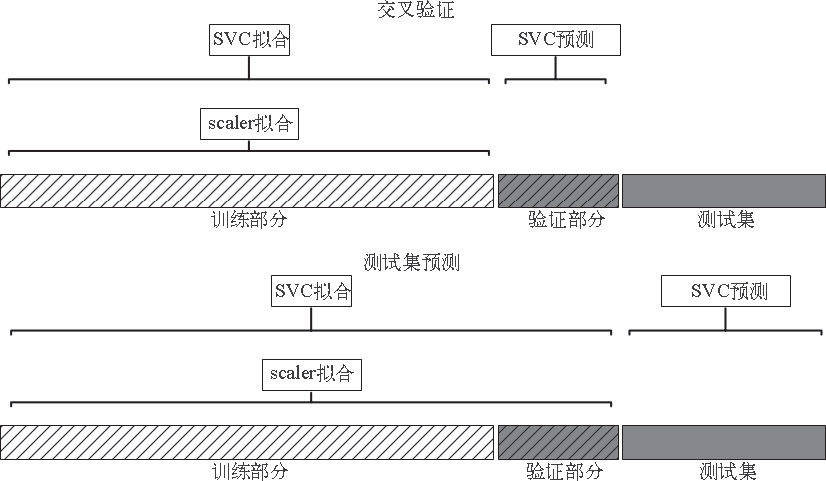

在交叉验证中，信息泄露的影响大小取决于预处理步骤的性质。使用测试部分来估计数据的范围，通常不会产生可怕的影响，但在特征提取和特征选择中使用测试部分，则会导致结果的显著差异。

##### 举例说明信息泄露
在`Hastie`、`Tibshirani`与`Friedman`合著的《统计学习基础》一书中给出了交叉验证中信息泄露的一个很好的例子，这里我们复制了一个修改版本。我们考虑一个假想的回归任务，包含从高斯分布中独立采样的$100$个样本与$10000$个特征。我们还从高斯分布中对响应进行采样：

In [5]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

考虑到我们创建数据集的方式，数据$X$与目标$y$之间没有任何关系，所以应该不可能从这个数据集中学到任何内容。现在我们将完成下列工作：首先利用`SelectPercentile`特征选择从$10000$个特征中选择信息量最大的特征，然后使用交叉验证对`Ridge`回归进行评估：

In [6]:
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)

print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

Cross-validation accuracy (cv only on ridge): 0.91


交叉验证计算得到的平均$R^2$为$0.91$，表示这是一个非常好的模型。这显然是不对的，因为我们的数据是完全随机的。这里的特征选择从$10000$个随机特征中(碰巧)选出了与目标相关性非常好的一些特征。由于我们在交叉验证之外对特征选择进行拟合，所以它能够找到在训练部分和测试部分都相关的特征。从测试部分泄露出去的信息包含的信息量非常大，导致得到非常不切实际的结果。我们将这个结果与正确的交叉验证(使用管道)进行对比：

In [7]:
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
         np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


这一次我们得到了负的$R^2$分数，表示模型很差。利用管道，特征选择现在位于交叉验证循环内部。也就是说，仅使用数据的训练部分来选择特征，而不使用测试部分。特征选择找到的特征在训练集中与目标相关，但由于数据是完全随机的，这些特征在测试集中并不与目标相关。在这个例子中，修正特征选择中的数据泄露问题，结论也由“模型表现很好”变为“模型根本没有效果”。


## 6.4 通用的管道接口
`Pipeline`类不但可用于预处理和分类，实际上还可以将任意数量的估计器连接在一起。

对于管道中估计器的唯一要求就是，除了最后一步之外的所有步骤都需要具有`transform`方法，这样它们可以生成新的数据表示，以供下一个步骤使用。

在调用`Pipeline.fit`的过程中，管道内部依次对每个步骤调用`fit`和`transform`(或仅调用`fit_transform`)，其输入是前一个步骤中`transform`方法的输出。对于管道中的最后一步，则仅调用`fit`。

忽略某些细枝末节，其实现方法如下所示。请记住，`pipeline.steps`是由元组组成的列表，所以`pipeline.steps[0][1]`是第一个估计器，`pipeline.steps[1][1]`是第二个估计器，以此类推：

```python
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 遍历除最后一步之外的所有步骤
        # 对数据进行拟合和变换
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 对最后一步进行拟合
    self.steps[-1][1].fit(X_transformed, y)
    return self
```

使用`Pipeline`进行预测时，我们同样利用除最后一步之外的所有步骤对数据进行变换(`transform`)，然后对最后一步调用`predict`：

```python
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 遍历除最后一步之外的所有步骤
        # 对数据进行变换
        X_transformed = step[1].transform(X_transformed)

# 利用最后一步进行预测
return self.steps[-1][1].predict(X_transformed)
```

整个过程如`图6-3`所示，其中包含两个变换器T1和T2，还有一个分类器(叫作`Classifier`)：
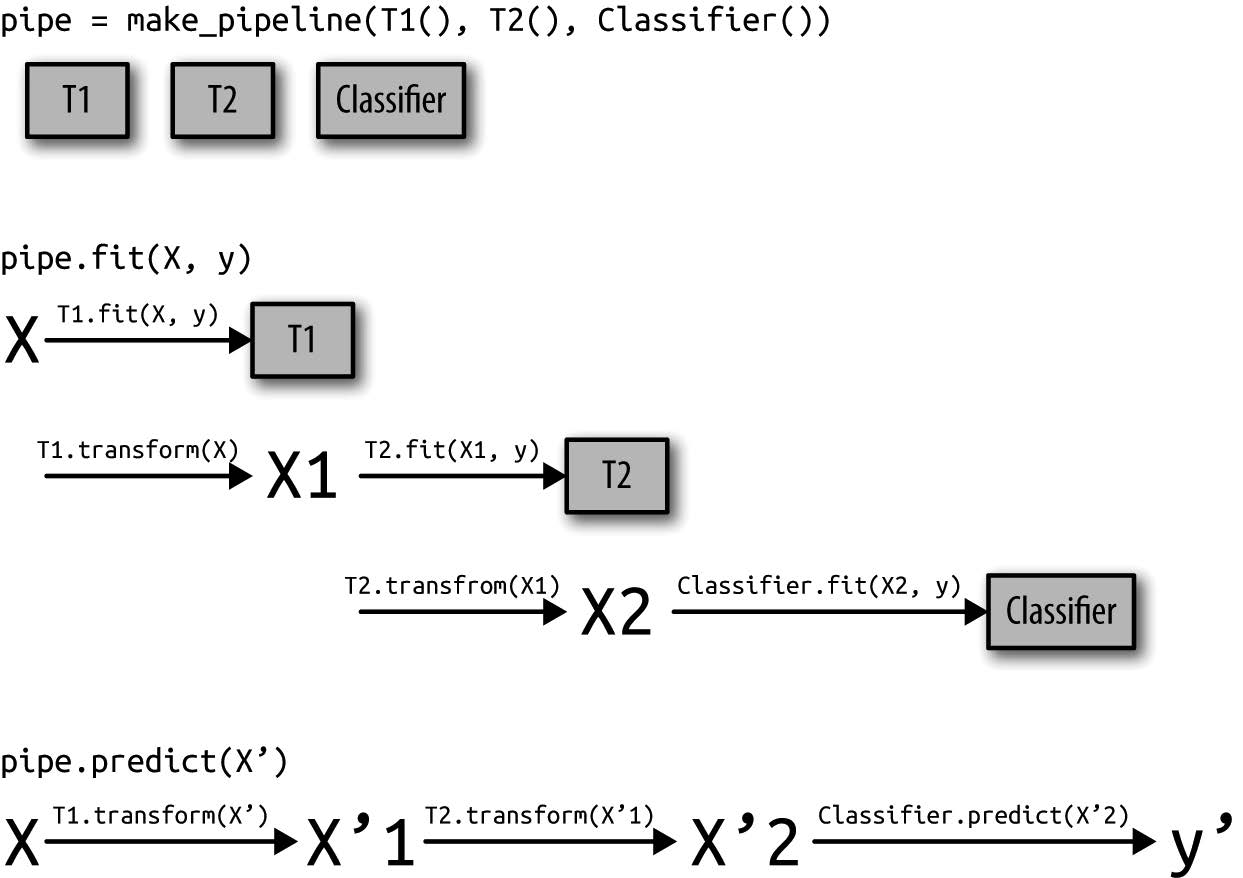

管道实际上比上图更加通用。管道的最后一步不需要具有`predict`函数。比如说，我们可以创建一个只包含一个缩放器和一个`PCA`的管道。由于最后一步`PCA`具有`transform`方法，所以我们可以对管道调用`transform`，以得到将`PCA.transform`应用于前一个步骤处理过的数据后得到的输出。管道的最后一步只需要具有`fit`方法。



### 6.4.1 用make_pipeline方便地创建管道
利用上述语法创建管道有时有点麻烦，我们通常不需要为每一个步骤提供用户指定的名称。`make_pipeline`可以为我们创建管道并根据每个步骤所属的类为其自动命名。`make_pipeline`的语法如下所示：

In [8]:
from sklearn.pipeline import make_pipeline

# 标准语法
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 缩写语法
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

pipe_short.steps

[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]

一般来说，步骤名称只是类名称的小写版本。如果多个步骤属于同一个类，则会附加一个数字：

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
pipe.steps

[('standardscaler-1',
  StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('pca',
  PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('standardscaler-2',
  StandardScaler(copy=True, with_mean=True, with_std=True))]

### 6.4.2 访问步骤属性
通过`named_steps`属性可以访问管道中的步骤，它是一个字典，将步骤名称映射为估计器：

In [10]:
# 用前面定义的管道对cancer数据集进行拟合
pipe.fit(cancer.data)

# 从"pca"步骤中提取前两个主成分
components = pipe.named_steps["pca"].components_
components.shape

(2, 30)

### 6.4.3 访问网格搜索管道中的属性
使用管道的主要原因之一就是进行网格搜索。一个常见的任务是在网格搜索内访问管道的某些步骤。例如，我们对`cancer数据集`上的`LogisticRegression`分类器进行网格搜索，在将数据传入`LogisticRegression`分类器之前，先用`Pipeline`和`StandardScaler`对数据进行缩放：

In [11]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

# LogisticRegression步骤的名称是小写的类名称logisticregression
# 为了调节参数C，我们必须指定logisticregression__C的参数网格
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

`GridSearchCV`找到的最佳模型(在所有训练数据上训练得到的模型)保存在`grid.best_estimator_`中，在我们的例子中，`best_estimator_`是一个管道，它包含两个步骤：`standardscaler`和`logisticregression`。如前所述，我们可以使用管道的`named_steps`属性来访问`logisticregression`步骤：

In [12]:
grid.best_estimator_.named_steps["logisticregression"]

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

现在我们得到了训练过的`LogisticRegression`实例，我们可以访问与每个输入特征相关的系数(权重)：

In [13]:
grid.best_estimator_.named_steps["logisticregression"].coef_

array([[-0.38856355, -0.37529972, -0.37624793, -0.39649439, -0.11519359,
         0.01709608, -0.3550729 , -0.38995414, -0.05780518,  0.20879795,
        -0.49487753, -0.0036321 , -0.37122718, -0.38337777, -0.04488715,
         0.19752816,  0.00424822, -0.04857196,  0.21023226,  0.22444999,
        -0.54669761, -0.52542026, -0.49881157, -0.51451071, -0.39256847,
        -0.12293451, -0.38827425, -0.4169485 , -0.32533663, -0.13926972]])

## 6.5 网格搜索预处理步骤与模型参数
我们可以利用管道将机器学习工作流程中的所有处理步骤封装成一个`scikit-learn`估计器。这么做的另一个好处在于，现在我们可以使用监督任务(比如回归或分类)的输出来调节预处理参数。在前几章里，我们在应用岭回归之前使用了`boston数据集`的多项式特征。下面我们用一个管道来重复这个建模过程。管道包含3个步骤：缩放数据、计算多项式特征与岭回归：

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_boston

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

我们怎么知道选择几次多项式，或者是否选择多项式或交互项呢？理想情况下，我们希望根据分类结果来选择`degree`参数。我们可以利用管道搜索`degree`参数以及`Ridge`的`alpha`参数。为了做到这一点，我们要定义一个包含这两个参数的`param_grid`，并用步骤名称作为前缀：

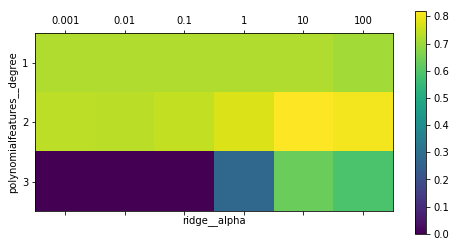

In [15]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
            vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(param_grid['ridge__alpha'])), param_grid['ridge__alpha'])
plt.yticks(range(len(param_grid['polynomialfeatures__degree'])),
           param_grid['polynomialfeatures__degree'])

plt.colorbar()
plt.show()

从交叉验证的结果中可以看出，使用二次多项式很有用，但三次多项式的效果比一次或二次都要差很多。从找到的最佳参数中也可以看出这一点：

In [16]:
grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}

这个最佳参数对应的分数如下：

In [17]:
grid.score(X_test, y_test)

0.76735803503061639

为了对比，我们运行一个没有多项式特征的网格搜索：

In [18]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.6271780381774581

同时搜索预处理参数与模型参数是一个非常强大的策略。但是要记住，`GridSearchCV`会尝试指定参数的所有可能组合。因此，向网格中添加更多参数，需要构建的模型数量将呈指数增长。


## 6.6 网格搜索选择使用哪个模型
可以进一步将`GridSearchCV`和`Pipeline`结合起来：还可以搜索管道中正在执行的实际步骤(比如用`StandardScaler`还是用`MinMaxScaler`)。这样会导致更大的搜索空间，应该予以仔细考虑。

尝试所有可能的解决方案，通常并不是一种可行的机器学习策略。但下面是一个例子：在`iris数据集`上比较`RandomForestClassifier`和`SVC`。我们知道，`SVC`可能需要对数据进行缩放，而`RandomForestClassifier`不需要预处理，所以我们还需要搜索是使用`StandardScaler`还是不使用预处理：

In [19]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier__C': 10, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True), 'classifier__gamma': 0.01, 'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)}

Best cross-validation score: 0.99
Test-set score: 0.98


网格搜索的结果是`SVC`与`StandardScaler`预处理，在$C=10$和$gamma=0.01$时给出最佳结果。

## 6.7 小结与展望
`Pipeline`类是一种通用工具，可以将机器学习工作流程中的多个处理步骤链接在一起。现实世界中的机器学习应用很少仅涉及模型的单独使用，而是需要一系列处理步骤。使用管道可以将多个步骤封装为单个`Python`对象，这个对象具有我们熟悉的接口`fit`、`predict`和`transform`。特别是使用交叉验证进行模型评估与使用网格搜索进行参数选择时，使用`Pipeline`类来包括所有处理步骤对正确的评估至关重要。利用`Pipeline`类还可以让代码更加简洁，并减少不用`pipeline`类构建处理链时可能会犯的错误(比如忘记将所有变换器应用于测试集，或者应用顺序错误)的可能性。选择特征提取、预处理和模型的正确组合，这在某种程度上是一门艺术，通常需要一些试错。但是有了管道，这种“尝试”多个不同的处理步骤是非常简单的。在进行试验时，要小心不要将处理过程复杂化，并且一定要评估一下模型中的每个组件是否必要。

学完本章，我们已经学完了`scikit-learn`提供的所有通用工具与算法。现在你已经掌握了所有必要的技术，并了解了在实践中应用机器学习的必要机制。下一章我们将深入一种在实践中常见的数据类型——文本数据，它需要具备一些专门的知识才能正确处理。